# AISEL -- Pedestrian Detector 
based on the PHD Thesis of Michael Greiffenhagen: "Engineering, Statistical Modeling and Performance Characterization of a Real-Time Dual Camera Surveillance System" Erlangen 2001
## Module 3: Indexing for Hypothesis Generation</p>

In [1]:
import os
import cv2
import sys
import numpy as np
import time
import matplotlib.pyplot as plt
plt.set_loglevel("error")
from scipy.spatial import distance
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Rectangle

import pyro
import torch


import pyro.infer
import pyro.optim
import pyro.distributions as dist

%matplotlib notebook

In /home/thraki/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/thraki/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/thraki/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/thraki/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/thraki/.local/lib/python3.6/site-packages/matplotlib/mpl-data/s

Load pedestrian video file from epfl from https://www.epfl.ch/labs/cvlab/data/data-pom-index-php/.

## Part 1: Indexing for Hypothesis Generation
Generate regions of interests, where potential pedestrians could  be located with quantifiable probabilites for false alarm and miss detections

In [2]:
!wget https://github.com/ccc-frankfurt/aisel-hands-on/blob/main/data/epflpedestshort.avi?raw=true

Will not apply HSTS. The HSTS database must be a regular and non-world-writable file.
ERROR: could not open HSTS store at '/home/thraki/.wget-hsts'. HSTS will be disabled.
--2020-11-12 11:03:49--  https://github.com/ccc-frankfurt/aisel-hands-on/blob/main/data/epflpedestshort.avi?raw=true
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/ccc-frankfurt/aisel-hands-on/raw/main/data/epflpedestshort.avi [following]
--2020-11-12 11:03:49--  https://github.com/ccc-frankfurt/aisel-hands-on/raw/main/data/epflpedestshort.avi
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ccc-frankfurt/aisel-hands-on/main/data/epflpedestshort.avi [following]
--2020-11-12 11:03:49--  https://raw.githubusercontent.com/ccc-frankfurt/aisel-hands-on/main/data/epflpedestshort.avi


In [3]:
file ='./epflpedestshort.avi?raw=true'
cap = cv2.VideoCapture(file)

In Module 1 we introduced the illumination invariant normalised color channels r and g. We will use them as input to the background modelling.

In [4]:
def get_normalised_channels(img, pix=None):
    """Extract BGR channel of an image and return normalised r and g channels."""
    if pix:
        b,g,r = img[pix[0]][pix[1]]
    else:
        b,g,r = cv2.split(img)
    # Intensities are stored as int8, upcast for mathematical operations
    b = b.astype('int16');g = g.astype('int16');r = r.astype('int16')
    # Calculate vectorised sum over all channels
    rgb = np.add(r,np.add(b,g))
    # Calculate vectorised normalised channels
    r_norm = np.divide(r,rgb)
    g_norm = np.divide(g,rgb)
    return r_norm, g_norm

In [5]:
def get_cov(r_norm_vid, g_norm_vid):
    """Input wo matrices containing tuples, calulate elementwise the covariance and return the inverse of covariance matrices."""
    # Not vectorised for demo reasons, in production-> vectorise all numpy operations
    x,y = r_norm_vid[0].shape
    result = []
    last_inv_cov = None
    for i in range(x):
        for j in range(y):
            r_norm_pix = [r[i,j] for r in r_norm_vid]
            g_norm_pix = [g[i,j] for g in g_norm_vid]
            cov = np.cov(r_norm_pix,g_norm_pix)
            #cov = np.cov(r_norm_pix[~np.isnan(r_norm_pix)],g_norm_pix[~np.isnan(g_norm_pix)])
            ## hack to deal with non invertible cov matrices, replace with noise
            try:
                inv_cov =  np.linalg.inv(cov)
                last_inv_cov = inv_cov
            except:
                print("picked last cov mat @",i,j)
                inv_cov = last_inv_cov                          
            result.append(inv_cov)
    result = np.array(result)
    return result,(x,y)

In [6]:
def get_mahaldist(mu_b_arr,mu_c_arr,inv_cov_arr):
    "Returns mahalanobis distance measure for matrices of tuples and one matrix of 2X2 inverse covariance matrices"
    ## Not vectorised for demo reasons: In production-> vectorise all numpy operations
    x,y,z = mu_c.shape   
    result = []
    for i in range(x):
        for j in range(y):         
            d2 = distance.mahalanobis(mu_b_arr[i][j],mu_c_arr[i][j],inv_cov_arr[i][j])
            result.append(d2)
    return np.reshape(result,(x,y))


In [7]:
# containers to track evolution of mean
r_norm_vid = []; g_norm_vid = []

# limit frames to the first appearing in the video
i_frame=0
cap = cv2.VideoCapture(file)

success = True
while success:
    # get frame
    (success, frame) = cap.read()
    if not success :
        continue
    # our main call to get normalised channels
    r_norm, g_norm  = get_normalised_channels(frame)
    
    r_norm_vid.append(r_norm)
    g_norm_vid.append(g_norm)
    
    i_frame=i_frame+1
    #if i_frame>1000: # limit frames to the first appearing in the video
    #    break
    

Now build our candidate for the background mean estimate $\mu_b$

In [8]:
mu_b = np.stack((np.nanmean(r_norm_vid,axis=0),np.nanmean(g_norm_vid,axis=0)),axis=2)

In [9]:
inv_cov_mat, cov_shape = get_cov(r_norm_vid, g_norm_vid)

In [10]:
cov_mat_2d = np.reshape(inv_cov_mat, (cov_shape[0], cov_shape[1],2,2) )

In [11]:
## Loop over the video and save for constant mu_b and constant covariance matrix 
cap = cv2.VideoCapture(file)

d2_container = {}
mu_c_r_container = {}

i_frame = 0

success = True
while success:
    # get frame
    (success, frame) = cap.read()
    if not success :
        continue
    #if i_frame > 400:
    #    break
   
    r_norm, g_norm  = get_normalised_channels(frame)    
    
    mu_c = (r_norm, g_norm)
    mu_c = np.stack((r_norm,g_norm),axis=2)
    mu_c_r_container[i_frame] = mu_c
    
    d2 = get_mahaldist(mu_b,mu_c, cov_mat_2d)
    d2_container[i_frame] = d2
    
    i_frame = i_frame+1
    
    
cap.release()
cv2.destroyAllWindows()

In [65]:
fig,ax = plt.subplots(1,2,figsize=(10, 4))
i_frame = 0
cap = cv2.VideoCapture(file)

is_cb = False
success = True
while success:
    # get frame
    (success, frame) = cap.read()
    if not success :
        continue
    if i_frame > len(d2_container):
        break
   
    #frame = frame[x1:x2,y1:y2]    
    ax[0].set_title("Orig. video")
    ax[0].imshow(frame)
    # display original frame 
    ax[1].set_title('Change Detection via Mahal. d2')
    ax[1].set_xlabel('Dark values indicate background',fontsize=14)    
    
    ax_handle = ax[1].imshow(d2_container[i_frame],cmap="gray",vmin=0, vmax=10)

    if not is_cb:
        # to do: cb is fixed to first frame, update colorbar
        divider = make_axes_locatable(ax[1])
        cax = divider.append_axes("right", size="20%", pad=0.05)
        plt.colorbar(ax_handle,cax=cax)
        is_cb = True
        # directives for plotting and layout
    plt.tight_layout()
    fig.canvas.draw()
    #time.sleep(0.0001)
    # cleanup directives
    ax[0].clear()
    ax[1].clear()
    i_frame = i_frame+1
    
    #if cv2.waitKey(1) & 0xFF == ord('q'):
    #    break
cap.release()
cv2.destroyAllWindows()

<IPython.core.display.Javascript object>

Identify Region of Interests (ROI) that could potentially contain pedestrians with quantifiable probabilites for false alarms $\alpha_f$ and miss-detection $\alpha_m$. 


A pedestrian may be modelled with a cylinder, which projection on a 2D plane can be approximated/calculated.
We assume pedestrians are upright and start with a index function that identifies lines in y-direction with changinge consequent pixels.

Look at the vertical lines in y direction and sum

<IPython.core.display.Javascript object>


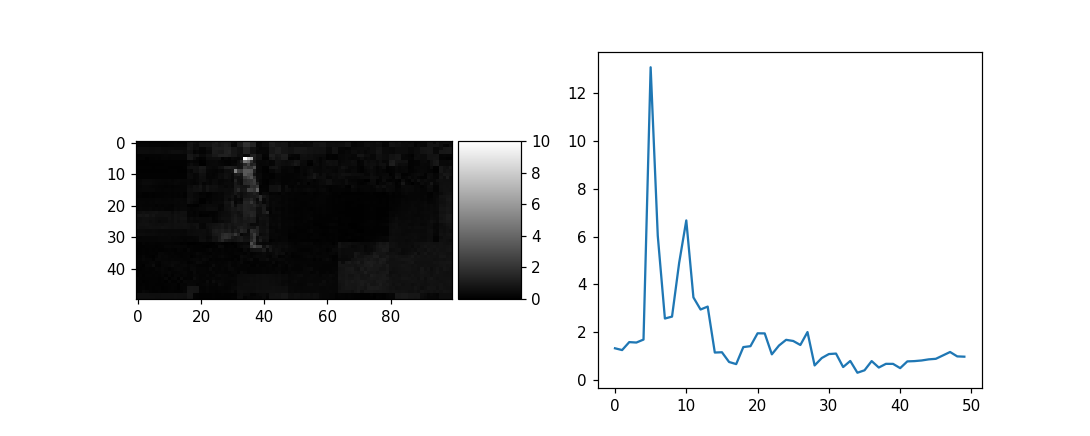

In [67]:
fig,ax = plt.subplots(1,2,figsize=(10, 4))
ax[0].imshow(d2_container[100],cmap="gray",vmin=0, vmax=20)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="20%", pad=0.05)
plt.colorbar(ax_handle,cax=cax)

ax[1].plot(d2_container[99][:,33:34].flatten())

In [15]:
d2_frame =  d2_container[100]
ny_pix = d2_frame.shape[0]
nx_pix = d2_frame.shape[1]

In [16]:
#Use these to control false alarms $\alpha_f$ and miss-detection $\alpha_m$. 
threshold = 40 # threshold for sum of d2 to separate active regions
max_single_pix_thres = 5 # at least one pixel in the estimator must have a value larger than this

In [17]:
def get_active_areas(img, threshold = 40, max_single_pix_thres = 5 ): # this is the region of interest algorithm
    """ get active areas from 2D aray of mahalabonis distances"""
    ##ToDo: FIND ONE or distinct areas of CHANGE IN y direction, no cut on y, yet... 
    ny_pix = img.shape[0]
    nx_pix = img.shape[1]
   
    y_line_estimates = []
    
    for i in range(nx_pix):
        x1=i
        y_line_est = np.zeros(img.shape,dtype=bool)
        d2_sum = img[:,x1].flatten().sum()
        max_d2 = max(img[:,x1].flatten())
        if d2_sum > threshold and max_d2 > max_single_pix_thres: 
            y_line_est[:,x1] = True
            y_line_estimates.append( y_line_est )
    return y_line_estimates

In [18]:
y_line_estimates = get_active_areas(d2_frame)

In [19]:
areas_of_interest_cont = np.zeros(y_line_estimates[0].shape,dtype=bool)
for y_line in y_line_estimates:
    areas_of_interest_cont = np.ma.mask_or(areas_of_interest_cont ,y_line) 

<IPython.core.display.Javascript object>


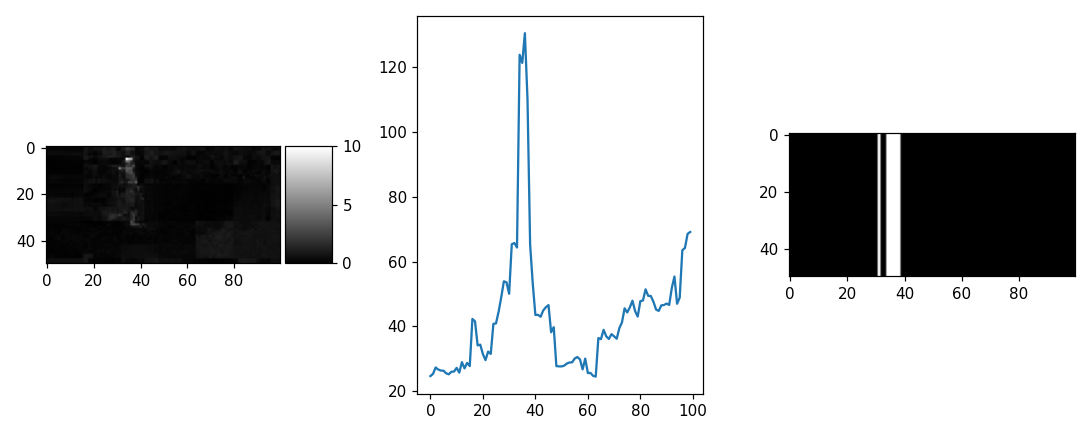

In [66]:
fig,ax = plt.subplots(1,3,figsize=(10, 4))
ax[0].imshow(d2_frame,cmap="gray",vmin=0, vmax=20)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="20%", pad=0.05)
plt.colorbar(ax_handle,cax=cax)
ax[1].plot(d2_frame.sum(axis=0))
ax[2].imshow(areas_of_interest_cont, cmap="gray",vmin=0, vmax=1)
plt.tight_layout()

### How to ensure that our algorithm has false alarms with probability $\alpha_f$ and miss-detection with probability $\alpha_m$? 

Let us look back at the parameters we have set for selecting active ROI. 

Threshold for sum of d2 to separate active regions.

At least one pixel in the estimator must have a value larger than this.


Recall how the behaviour of the estimator d2 is characterised for each pixel: 
The distribution of this statistic follows approximately a chi-squared distributed with 2 degrees of freedom.
If we assume it is a background pixel, then d2 follows a chi-square distribution $d2 ∼ \chi^2$ with non-centrality parameter = 0. That is if we know all parameters of the relation $d2 ∼ \chi^2$ we can set the threshold so that e.g. false alarms with probability $\alpha_f=0.05$ by identifiying the cutoff value d2_cutoff of the $d2 ∼ \chi^2$ distribution so that the tail of the distribution corresponding to 5% of the area under the curve,

In [21]:
len(np.array([arr for (frame_n, arr) in d2_container.items()]).flatten())

3000000

In [22]:
i=2;j=99

In [23]:


d2_pix_frame = {(frame_n,arr[i][j]) for (frame_n, arr) in d2_container.items()}


In [24]:
d2_pix = [x[1] for x in list(d2_pix_frame)]

chi2 square distribution with degrees of freedom = 1 and 2 and non centrality parameter $\lambda$ = 0, wich $\lambda$ being the squared some of the means of the random variables

In [25]:
m2 = torch.distributions.chi2.Chi2(torch.tensor([2]))   
m1 = torch.distributions.chi2.Chi2(torch.tensor([1]))  

In [26]:
dist_m1_chi2= [ m1.sample().numpy().data[0] for n in range(10000)]
dist_m2_chi2= [ m2.sample().numpy().data[0] for n in range(10000)]

At which cutoff do we expect a false alaram rate of 5% per pixel? Note this is not yet our previously calculated region of interest.

In [27]:
np.percentile(dist_m1_chi2, 95), np.percentile(dist_m2_chi2, 95)

(3.8145780801773044, 5.935578250885007)

In [28]:
d2_tensor = torch.FloatTensor(d2_pix); log_weights = torch.ones(np.shape(d2_pix))

<IPython.core.display.Javascript object>


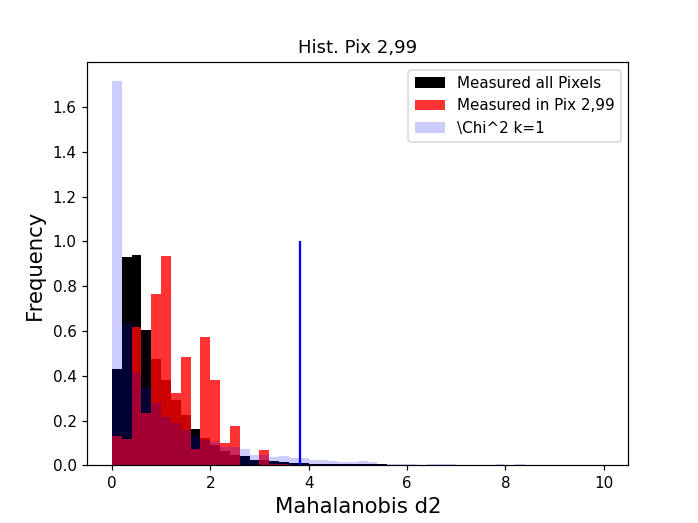

In [35]:
fig,ax = plt.subplots(1)
bins = 50

ax.set_title('Hist. Pix '+str(i)+','+str(j))
ax.set_xlabel('Mahalanobis d2', fontsize=14)
ax.set_ylabel('Frequency ', fontsize=14)


ax.hist(np.array([arr for (frame_n, arr) in d2_container.items()]).flatten(),bins = bins,color="black",alpha=1, range=[0,10], density =True, label= 'Measured all Pixels' )

ax.hist(d2_pix,bins = bins, color="red", alpha=0.8,range=[0,10],density = True, label= 'Measured in Pix '+str(i)+','+str(j) )

ax.hist(dist_m1_chi2,bins = bins,color="blue",alpha=0.2,range=[0,10],density = True, label= '\Chi^2 k=1')
ax.vlines( np.percentile(dist_m1_chi2, 95),0,1, color = "blue")

ax.hist(dist_m2_chi2,bins = bins,color="blue",ls='dashed',alpha=0.8,range=[0,10],density = True, label= '\Chi^2 k=2')
ax.vlines( np.percentile(dist_m2_chi2, 95),0,1, color = "blue",ls='dashed')
#ax.hist(h_emp_dist,bins = bins,color="green",alpha=0.1, range=[0,10], density = True)


plt.legend()
fig.canvas.draw()

Is the assumption of having a probability function of this particular form valid?  How can you estimate better suited probability density functions?

How can you ensure that the false alarm rates are still valid after operationg the system for a while. What kind of check can be done on a regular basis?

If we assume the content of a pixel to be stemming from a pedestrian moving aorund, then we have seen that d2 follows a chi-square distribution with a non-centrality parameter different from zero: 
$d2 ∼ \chi(c_{\Theta})^2$ with $c_{\Theta} != 0$

 Exercise: Calculate numerically the parameters for our region of interest algorithm and so that false alarms with probability of $\alpha_f=0.05$ occur. Write down in a sentence a under which circumstances this is valid.

<IPython.core.display.Javascript object>


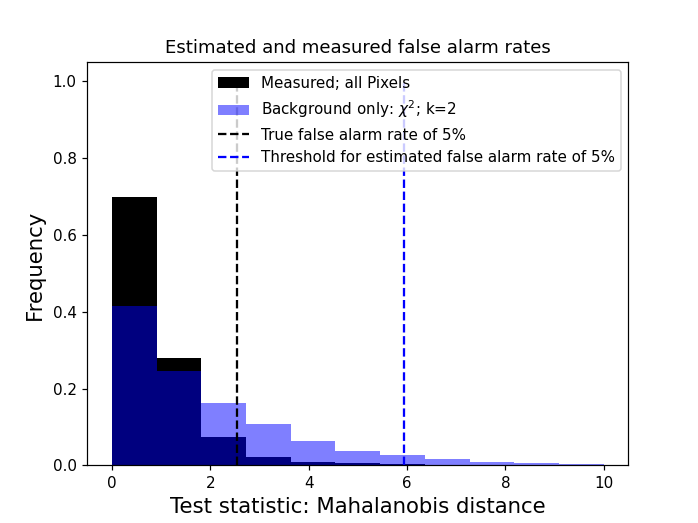

In [61]:
fig,ax = plt.subplots(1)
bins = 11

ax.set_title('Estimated and measured false alarm rates')
ax.set_xlabel('Test statistic: Mahalanobis distance', fontsize=14)
ax.set_ylabel('Frequency ', fontsize=14)

all_pixels = np.array([arr for (frame_n, arr) in d2_container.items()]).flatten()
ax.hist(all_pixels,bins = bins,color="black",alpha=1, range=[0,10], density =True,label= 'Measured; all Pixels' )
ax.vlines( np.percentile(all_pixels, 95),0,1, color = "black",ls='dashed', label='True false alarm rate of 5%')
#ax.hist(d2_pix,bins = bins, color="red", alpha=0.8,range=[0,10],density = True, label= 'Measured in Pix '+str(i)+','+str(j) )

#ax.hist(dist_m1_chi2,bins = bins,color="blue",alpha=0.2,range=[0,10],density = True, label= '$\chi^2$; k=1')
#ax.vlines( np.percentile(dist_m1_chi2, 95),0,1, color = "blue")

ax.hist(dist_m2_chi2,bins = bins,color="blue",ls='dashed',alpha=0.5,range=[0,10],density = True, label= 'Background only: $\chi^2$; k=2')
ax.vlines( np.percentile(dist_m2_chi2, 95),0,1, color = "blue",ls='dashed', label='Threshold for estimated false alarm rate of 5%')
#ax.hist(h_emp_dist,bins = bins,color="green",alpha=0.1, range=[0,10], density = True)


plt.legend()
fig.canvas.draw()

<IPython.core.display.Javascript object>


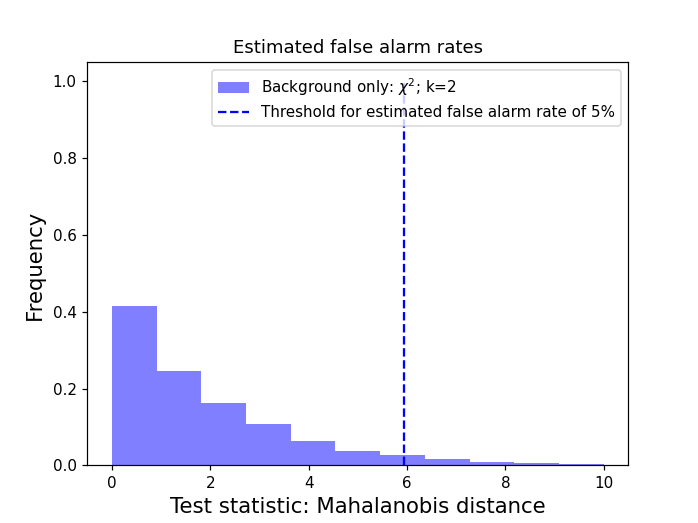

In [64]:
fig,ax = plt.subplots(1)
bins = 11

ax.set_title('Estimated false alarm rates')
ax.set_xlabel('Test statistic: Mahalanobis distance', fontsize=14)
ax.set_ylabel('Frequency ', fontsize=14)

all_pixels = np.array([arr for (frame_n, arr) in d2_container.items()]).flatten()
#ax.hist(all_pixels,bins = bins,color="black",alpha=1, range=[0,10], density =True,label= 'Measured; all Pixels' )
#ax.vlines( np.percentile(all_pixels, 95),0,1, color = "black",ls='dashed', label='True false alarm rate of 5%')
#ax.hist(d2_pix,bins = bins, color="red", alpha=0.8,range=[0,10],density = True, label= 'Measured in Pix '+str(i)+','+str(j) )

#ax.hist(dist_m1_chi2,bins = bins,color="blue",alpha=0.2,range=[0,10],density = True, label= '$\chi^2$; k=1')
#ax.vlines( np.percentile(dist_m1_chi2, 95),0,1, color = "blue")

ax.hist(dist_m2_chi2,bins = bins,color="blue",ls='dashed',alpha=0.5,range=[0,10],density = True, label= 'Background only: $\chi^2$; k=2')
ax.vlines( np.percentile(dist_m2_chi2, 95),0,1, color = "blue",ls='dashed', label='Threshold for estimated false alarm rate of 5%')
#ax.hist(h_emp_dist,bins = bins,color="green",alpha=0.1, range=[0,10], density = True)


plt.legend()
fig.canvas.draw()

In [36]:
# Empirical distribution encodes distribution as seen in data, advantage: you can draw (bootstrap) from this distribution 
emp_dist = dist.Empirical(d2_tensor,log_weights)


In [37]:
h_emp_dist= [ emp_dist.sample().numpy().reshape(1)[0] for n in range(600)]

In [38]:
import torch.nn.functional as F


In [39]:
torch.FloatTensor(h_emp_dist).shape

torch.Size([600])

In [40]:
torch.FloatTensor(chi2_tensor).shape

NameError: name 'chi2_tensor' is not defined

In [41]:
out = F.kl_div(torch.FloatTensor(h_emp_dist), chi2_tensor)

NameError: name 'chi2_tensor' is not defined